In [70]:
%%capture
!rm -rf shakespeare_data/plays_xml
!unzip -P rtad shakespeare_data/plays.zip -d shakespeare_data/plays_xml

In [71]:
%%capture
import numpy as np 
import networkx as nx #graphing
from lxml import etree #parsing xml
import itertools 
from datascience import *
import matplotlib.pyplot as plt #plotting library
%matplotlib inline

# Social Network Analysis: NetworkX

Mark Algee-Hewitt looks at thousands of plays across centuries. But as we've learned so far, to do this we first have to figure out how to calculate the metrics we're interested in for a single text. Let's take a look at a single play. Luckily, there are databases that exists that have already annotated a lot of plays in a markup language called XML. Especially well researched corpora have extensive metadata. We'll look at the Shakespeare corpus with data obtained from https://www.playshakespeare.com/ .

We'll start by looking at *Othello*.

In [72]:
with open("shakespeare_data/plays_xml/othello_ps_v3.xml") as f:
    othello_xml = etree.fromstring(f.read().encode())

If we're trying to build a network we need two things: 1) nodes and 2) edges. For Algee-Hewitt, and for us today, that means we need to know the characters in *Othello*, and with whom they communicate. We'd also like to know how often that specific interaction occurs.

We can get all elements of the XML tree by `iter`ating over all the nodes:

In [73]:
all_elements = list(othello_xml.iter())
all_elements

[<Element play at 0x7f862f821dc8>,
 <Element title at 0x7f862f767508>,
 <Element playwright at 0x7f862f767648>,
 <Element act at 0x7f862f7674c8>,
 <Element acttitle at 0x7f862f7675c8>,
 <Element scene at 0x7f862f767608>,
 <Element scenetitle at 0x7f862f767488>,
 <Element scenelocation at 0x7f862f759b48>,
 <Element scenepersonae at 0x7f862f7811c8>,
 <Element stagedir at 0x7f8628612848>,
 <Element speech at 0x7f862f7a6fc8>,
 <Element speaker at 0x7f862f7a6e88>,
 <Element line at 0x7f862f7a6f48>,
 <Element line at 0x7f862f7a6f08>,
 <Element line at 0x7f862f7a6e48>,
 <Element speech at 0x7f862f7a6ec8>,
 <Element speaker at 0x7f862f7454c8>,
 <Element line at 0x7f862854dc08>,
 <Element line at 0x7f862854da88>,
 <Element line at 0x7f862f8203c8>,
 <Element speech at 0x7f862f820bc8>,
 <Element speaker at 0x7f862f820d48>,
 <Element line at 0x7f862f8204c8>,
 <Element speech at 0x7f862f8208c8>,
 <Element speaker at 0x7f862f820c88>,
 <Element line at 0x7f862f820d08>,
 <Element line at 0x7f862f820c0

That's a lot of information! Let's grab out all of the speakers. All the `speaker` elements will have a `text` attribute that has their actual name, or abbreviation of their name.

In [74]:
[e.text for e in all_elements if e.tag == "speaker"]

['ROD.',
 'IAGO.',
 'ROD.',
 'IAGO.',
 'ROD.',
 'IAGO.',
 'ROD.',
 'IAGO.',
 'ROD.',
 'IAGO.',
 'ROD.',
 'IAGO.',
 'ROD.',
 'IAGO.',
 'BRA.',
 'ROD.',
 'IAGO.',
 'BRA.',
 'IAGO.',
 'BRA.',
 'ROD.',
 'BRA.',
 'ROD.',
 'BRA.',
 'ROD.',
 'BRA.',
 'ROD.',
 'BRA.',
 'ROD.',
 'IAGO.',
 'BRA.',
 'IAGO.',
 'BRA.',
 'IAGO.',
 'BRA.',
 'ROD.',
 'BRA.',
 'IAGO.',
 'BRA.',
 'ROD.',
 'BRA.',
 'ROD.',
 'BRA.',
 'ROD.',
 'BRA.',
 'IAGO.',
 'OTH.',
 'IAGO.',
 'OTH.',
 'IAGO.',
 'OTH.',
 'IAGO.',
 'OTH.',
 'CAS.',
 'OTH.',
 'CAS.',
 'OTH.',
 'CAS.',
 'IAGO.',
 'CAS.',
 'IAGO.',
 'CAS.',
 'IAGO.',
 'OTH.',
 'CAS.',
 'IAGO.',
 'OTH.',
 'ROD.',
 'BRA.',
 'IAGO.',
 'OTH.',
 'BRA.',
 'OTH.',
 'BRA.',
 'OTH.',
 'OFF.',
 'BRA.',
 'DUKE.',
 '1. SEN.',
 'DUKE.',
 '2. SEN.',
 'DUKE.',
 'SAIL.',
 'OFF.',
 'DUKE.',
 'SAIL.',
 'DUKE.',
 '1. SEN.',
 'DUKE.',
 'OFF.',
 '1. MESS.',
 '1. SEN.',
 '1. MESS.',
 'DUKE.',
 '1. SEN.',
 'DUKE.',
 '1. SEN.',
 'DUKE.',
 'BRA.',
 'DUKE.',
 'BRA.',
 'ALL.',
 'BRA.',
 'DUKE.',
 'B

To get a unique list we'll use `set`:

In [75]:
set([e.text for e in all_elements if e.tag == "speaker"])

{'1. GENT.',
 '1. MESS.',
 '1. MUS.',
 '1. SEN.',
 '2. GENT.',
 '2. MESS.',
 '2. SEN.',
 '3. GENT.',
 'ALL.',
 'BIAN.',
 'BRA.',
 'CAS.',
 'CLO.',
 'DES.',
 'DUKE',
 'DUKE.',
 'EMIL.',
 'GENTLEMEN.',
 'GRA.',
 'HER.',
 'IAGO',
 'IAGO.',
 'LOD.',
 'MON.',
 'OFF.',
 'OTH.',
 'ROD.',
 'SAIL.'}

Great start! In Network Analysis there are two fundamental principles. A ***node*** is an entity, it can have relationships with other entities. In literature, this is often a character, but it could be a Twitter user, organization, geographic location, or even words!

We may be interested in a node's properties. If it's a character, we may want to know how often they speak, age, etc. We can add this to the network as further layers.

The second concept is an ***edge***. An edge connects nodes. We're foremost interested in the volume of connections between nodes. For literature, this would be the number of times two characters interact.

As we learned from Moretti and our readings for today, this is a very difficult task for most texts. Where does on character's speech end and another's begin? Luckily, in plays this is slightly easier to identify (though still not perfectly clear).

For Shakespeare, we'll settle for them being present in the same *scene*. If they're in the same scene together, we'll increase our measure of their interaction.

Thus for each character we want to know how many lines the speak in the entire play, along with which scenes they appear in. We can then collate this wil the other characters.

The `get_cast_dict` function below will parse the XML data and extract this information.

In [76]:
cast_dict = {}
for c in set([e.text for e in all_elements if e.tag == "speaker"]):
    cast_dict[c] = {"num_lines": 0,
                    "scenes": []}
    
cast_dict

{'1. GENT.': {'num_lines': 0, 'scenes': []},
 '1. MESS.': {'num_lines': 0, 'scenes': []},
 '1. MUS.': {'num_lines': 0, 'scenes': []},
 '1. SEN.': {'num_lines': 0, 'scenes': []},
 '2. GENT.': {'num_lines': 0, 'scenes': []},
 '2. MESS.': {'num_lines': 0, 'scenes': []},
 '2. SEN.': {'num_lines': 0, 'scenes': []},
 '3. GENT.': {'num_lines': 0, 'scenes': []},
 'ALL.': {'num_lines': 0, 'scenes': []},
 'BIAN.': {'num_lines': 0, 'scenes': []},
 'BRA.': {'num_lines': 0, 'scenes': []},
 'CAS.': {'num_lines': 0, 'scenes': []},
 'CLO.': {'num_lines': 0, 'scenes': []},
 'DES.': {'num_lines': 0, 'scenes': []},
 'DUKE': {'num_lines': 0, 'scenes': []},
 'DUKE.': {'num_lines': 0, 'scenes': []},
 'EMIL.': {'num_lines': 0, 'scenes': []},
 'GENTLEMEN.': {'num_lines': 0, 'scenes': []},
 'GRA.': {'num_lines': 0, 'scenes': []},
 'HER.': {'num_lines': 0, 'scenes': []},
 'IAGO': {'num_lines': 0, 'scenes': []},
 'IAGO.': {'num_lines': 0, 'scenes': []},
 'LOD.': {'num_lines': 0, 'scenes': []},
 'MON.': {'num_lin

In [77]:
# extract all scene elements from the xml
scenes = [e for e in all_elements if e.tag == "scene"]
scenes

[<Element scene at 0x7f862f767608>,
 <Element scene at 0x7f862f79e788>,
 <Element scene at 0x7f862f77d808>,
 <Element scene at 0x7f862f747588>,
 <Element scene at 0x7f862f7507c8>,
 <Element scene at 0x7f862f750a08>,
 <Element scene at 0x7f862f765208>,
 <Element scene at 0x7f862f76bdc8>,
 <Element scene at 0x7f862f72c348>,
 <Element scene at 0x7f862fc2f208>,
 <Element scene at 0x7f862fc38c88>,
 <Element scene at 0x7f862fc35148>,
 <Element scene at 0x7f862fc3d448>,
 <Element scene at 0x7f862fc4c448>,
 <Element scene at 0x7f862fc4f648>]

In [78]:
elements = [e.find("acttitle").text for e in all_elements if e.tag == "act"]

In [79]:
def get_cast_dict(all_elements):
    '''
    returns a dictionary with the total number of lines and scenes a character appears in
    '''
    
    cast_dict = {}
    
    # first get a unique set of all characters appearing in the play
    for c in set([e.text for e in all_elements if e.tag == "speaker"]):
        cast_dict[c] = {"num_lines": 0,
                        "scenes": []}
    
    # extract all scene elements from the xml
    scenes = [e for e in all_elements if e.tag == "scene"]
    acts = [e for e in all_elements if e.tag == "act"]
    # acts = [e.find("acttitle").text for e in all_elements if e.tag == "act"]
    
    for a in acts:
        
        # get title of acts
        act_title = a.find("acttitle").text
        
        # get scene elements
        scenes = [e for e in a if e.tag == "scene"]
        # iterate through each scene
        for sc in scenes:

            # grab all the speeches in the scene
            speeches = [s for s in sc.getchildren() if s.tag == "speech"]

            # iterate through speeches
            for s in speeches:

                # increment number of lines for the speaker
                cast_dict[s.find("speaker").text]["num_lines"] += len(s.findall("line"))

            # find all the speaker for each speech    
            speakers = [s.find("speaker").text for s in speeches]

            # add the title of the scene for each speaker appearing in the scene
            for s in set(speakers):
                cast_dict[s]["scenes"].append(act_title + " " + sc.find("scenetitle").text)

        # reassign scenes to only a unique set
        for c in cast_dict.keys():
            cast_dict[c]["scenes"] = list(set(cast_dict[c]["scenes"]))
            
    return cast_dict

In [80]:
cast_dict = get_cast_dict(all_elements)
cast_dict

{'1. GENT.': {'num_lines': 3, 'scenes': ['Act 2 Scene 1']},
 '1. MESS.': {'num_lines': 9, 'scenes': ['Act 1 Scene 3']},
 '1. MUS.': {'num_lines': 5, 'scenes': ['Act 3 Scene 1']},
 '1. SEN.': {'num_lines': 26, 'scenes': ['Act 1 Scene 3']},
 '2. GENT.': {'num_lines': 14, 'scenes': ['Act 2 Scene 1']},
 '2. MESS.': {'num_lines': 2, 'scenes': ['Act 2 Scene 1']},
 '2. SEN.': {'num_lines': 5, 'scenes': ['Act 1 Scene 3']},
 '3. GENT.': {'num_lines': 17, 'scenes': ['Act 2 Scene 1']},
 'ALL.': {'num_lines': 4,
  'scenes': ['Act 5 Scene 2', 'Act 2 Scene 3', 'Act 1 Scene 3']},
 'BIAN.': {'num_lines': 26,
  'scenes': ['Act 4 Scene 1', 'Act 5 Scene 1', 'Act 3 Scene 4']},
 'BRA.': {'num_lines': 139,
  'scenes': ['Act 1 Scene 1', 'Act 1 Scene 3', 'Act 1 Scene 2']},
 'CAS.': {'num_lines': 224,
  'scenes': ['Act 3 Scene 3',
   'Act 3 Scene 1',
   'Act 2 Scene 3',
   'Act 4 Scene 1',
   'Act 5 Scene 1',
   'Act 2 Scene 1',
   'Act 5 Scene 2',
   'Act 1 Scene 2',
   'Act 3 Scene 4']},
 'CLO.': {'num_lines

That's all we need to make a basic network and do some analysis! We have all the character names and the scenes in which they appear. We can collate some of this information to find out in which scenes certain characters appear together. This will happen in our `make_graph` function.

The `NetworkX` Python library will parse this dictionary for us to make a graph object. Let's write a function:

In [81]:
def make_graph(c_dict):
    '''
    This function accepts a dictionary with number of lines and scenes to create a
    NetworkX graph object
    '''
    # setup graph object
    G = nx.Graph()
    
    # add nodes with attributes of number of lines and scenes
    for c in c_dict.keys():
        if c_dict[c]["num_lines"] > 0:
            G.add_node(
                c,
                number_of_lines=c_dict[c]["num_lines"],
                scenes=c_dict[c]["scenes"]
            )

    # make edges by iterating over all combinations of nodes
    for (node1, data1), (node2, data2) in itertools.combinations(G.nodes(data=True), 2):

        # count scenes together by getting union of their sets
        scenes_together = len(set(data1['scenes']) & set(data2['scenes']))
        
        if scenes_together:
            # add more weight for more scenes together
            G.add_edge(node1, node2, weight=scenes_together)
            
    return G

In [82]:
G = make_graph(cast_dict)

We can graph this using `matplotlib`:

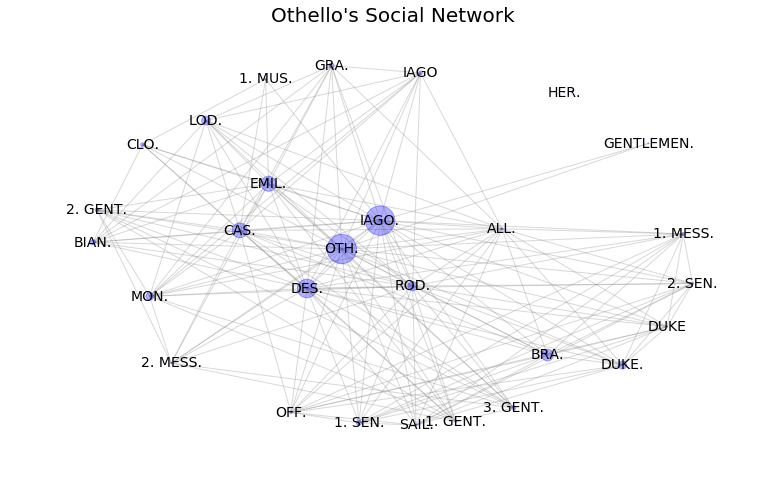

In [83]:
# nodes should be sized by number of lines
node_size = [data['number_of_lines'] for __, data in G.nodes(data=True)]
node_color = 'blue'

plt.figure(figsize=(13,8))  # make the figure size a little larger
plt.axis('off')  # remove the axis, which isn't meaningful in this case
plt.title("Othello's Social Network", fontsize=20)

# The 'k' argument determines how spaced out the nodes will be from
# one another on the graph.
pos = nx.spring_layout(G, k=0.5)

nx.draw_networkx(
    G,
    pos=pos,
    node_size=node_size,
    node_color=node_color,
    edge_color='gray',  # change edge color
    alpha=0.3,  # make nodes more transparent to make labels clearer
    font_size=14,
)

Our graph, `G`, is a powerful object. We can calculate many of the standard network analysis statistics. There are various measures of centrality, many of which were referenced in the reading.

In [84]:
network_tab = Table()
network_tab.append_column(label="Characters", values=[c for c in sorted(cast_dict.keys())])
network_tab.show()

Characters
1. GENT.
1. MESS.
1. MUS.
1. SEN.
2. GENT.
2. MESS.
2. SEN.
3. GENT.
ALL.
BIAN.


Wikipedia defines "[degree centrality](https://en.wikipedia.org/wiki/Centrality#Degree_centrality)":
>Historically first and conceptually simplest is degree centrality, which is defined as the number of links incident upon a node (i.e., the number of ties that a node has).

In [85]:
dc = [x[1] for x in sorted(nx.degree_centrality(G).items(), key=lambda x: x[0])]
network_tab.append_column(label="Degree Centrality", values=dc)
network_tab.show()

Characters,Degree Centrality
1. GENT.,0.37037
1. MESS.,0.444444
1. MUS.,0.148148
1. SEN.,0.444444
2. GENT.,0.37037
2. MESS.,0.37037
2. SEN.,0.444444
3. GENT.,0.37037
ALL.,0.666667
BIAN.,0.37037


Wikipedia defines "[betweeness centrality](https://en.wikipedia.org/wiki/Centrality#Betweenness_centrality)":

>Betweenness is a centrality measure of a vertex within a graph (there is also edge betweenness, which is not discussed here). Betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two other nodes.

In [86]:
bc = [x[1] for x in sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[0])]
network_tab.append_column(label="Betweenness Centrality", values=bc)
network_tab.show()

Characters,Degree Centrality,Betweenness Centrality
1. GENT.,0.37037,0
1. MESS.,0.444444,0
1. MUS.,0.148148,0
1. SEN.,0.444444,0
2. GENT.,0.37037,0
2. MESS.,0.37037,0
2. SEN.,0.444444,0
3. GENT.,0.37037,0
ALL.,0.666667,0.0242844
BIAN.,0.37037,0.00189934


Wikipedia defines "[eigenvector centrality](https://en.wikipedia.org/wiki/Centrality#Eigenvector_centrality)":
> Eigenvector centrality (also called eigencentrality) is a measure of the influence of a node in a network. It assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes.

>$x_v = \frac{1}{\lambda} \sum_{t \in M(v)}x_t = \frac{1}{\lambda} \sum_{t \in G} a_{v,t}x_t$

In [87]:
ec = [x[1] for x in sorted(nx.eigenvector_centrality(G).items(), key=lambda x: x[0])]
network_tab.append_column(label="Eigenvector Centrality", values=ec)
network_tab.show()

Characters,Degree Centrality,Betweenness Centrality,Eigenvector Centrality
1. GENT.,0.37037,0,0.0598252
1. MESS.,0.444444,0,0.0497307
1. MUS.,0.148148,0,0.0281452
1. SEN.,0.444444,0,0.0497307
2. GENT.,0.37037,0,0.0598252
2. MESS.,0.37037,0,0.0598252
2. SEN.,0.444444,0,0.0497307
3. GENT.,0.37037,0,0.0598252
ALL.,0.666667,0.0242844,0.153637
BIAN.,0.37037,0.00189934,0.141144


# Challenge

What is the overlap ((rank) correlation) between the three measurements presented above? What does that mean for the play?

# Bonus: Making a prettier graph

`matplotlib` isn't always the most beautiful option. A popular way of visualizing networks is by using Javascript's [D3](https://d3js.org/) library. Luckily, `networkx` allows us to export the network information to JSON:

In [88]:
from networkx.readwrite import json_graph
import json

d3_data = json_graph.node_link_data(G)
d3_data

{'directed': False,
 'graph': {},
 'links': [{'source': 0, 'target': 1, 'weight': 1},
  {'source': 0, 'target': 3, 'weight': 1},
  {'source': 0, 'target': 10, 'weight': 2},
  {'source': 0, 'target': 11, 'weight': 1},
  {'source': 0, 'target': 16, 'weight': 2},
  {'source': 0, 'target': 17, 'weight': 2},
  {'source': 0, 'target': 21, 'weight': 1},
  {'source': 0, 'target': 22, 'weight': 1},
  {'source': 0, 'target': 23, 'weight': 1},
  {'source': 0, 'target': 24, 'weight': 1},
  {'source': 0, 'target': 25, 'weight': 2},
  {'source': 1, 'target': 3, 'weight': 2},
  {'source': 1, 'target': 10, 'weight': 2},
  {'source': 1, 'target': 11, 'weight': 1},
  {'source': 1, 'target': 16, 'weight': 2},
  {'source': 1, 'target': 17, 'weight': 2},
  {'source': 1, 'target': 21, 'weight': 1},
  {'source': 1, 'target': 22, 'weight': 2},
  {'source': 1, 'target': 23, 'weight': 1},
  {'source': 1, 'target': 24, 'weight': 1},
  {'source': 1, 'target': 25, 'weight': 1},
  {'source': 2, 'target': 6, 'weight

We can then add this to a D3 template:

In [89]:
import re

with open('network.html', 'r') as f:
    net_html = f.read()

pattern = re.compile(r'(<script type="application/json" id="net">)(\s*.*)')
net_html = net_html.replace(re.findall(pattern, net_html)[-1][-1].strip(), json.dumps(d3_data).strip())

with open('network.html', 'w') as f:
    f.write(net_html)

We'll then `IFrame` in the HTML file

In [90]:
from IPython.display import IFrame
IFrame('network.html', width=700, height=900)

---

# Gini Coefficient

Algee-Hewitt was calculating the gini coefficient of the eigenvector centralities. He essentially wanted to know whether importance in a network was evenly distributed, or concentrated in the hands of a few. The lower the gini coefficient, the more equal the distribution, the closer to 1, the closer one gets to complete inequality. I've found a function online that will calculate the gini coefficient for you!

In [91]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # https://github.com/oliviaguest/gini
    array = np.sort(array) # values must be sorted
    index = np.arange(1, array.shape[0] + 1) # index per array element
    n = array.shape[0] # number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

Just to demonstrate, let's make a very unequal array:

In [92]:
np.concatenate((np.zeros(99), np.ones(1)))

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])

The gini coefficient should be close to 1:

In [93]:
gini(np.concatenate((np.zeros(99), np.ones(1))))

0.98999999999999999

What if we have half zeroes and half ones?

In [94]:
gini(np.concatenate((np.zeros(50), np.ones(50))))

0.5

All ones?

In [95]:
gini(np.ones(50))

0.0

Now we can use the `gini` function on *Othello* to see how evenly distributed centrality is:

In [96]:
import numpy as np
gini(network_tab['Eigenvector Centrality'])

0.47116713415209316

Great, but that's not terribly interesting itself, we want to see how it relates to other plays. We'll do that for homework. 

First, let's write a function to calculate Algee-Hewitt's second measure. He takes the percentage of characters in the top quartile of eigenvector centralities. You'll want to use the `np.percentile` method!

## Challenge

In [131]:
def percentage_top_quartile(character_table):
    # YOUR CODE HERE
    value = np.percentile(character_table, 25)
    boolean_array = character_table > value
    percentage = np.count_nonzero(boolean_array)/len(boolean_array)
    return percentage

In [132]:
percentage_top_quartile(network_tab['Eigenvector Centrality'])

0.6785714285714286

# Homework

I've downloaded 40 other Shakespeare texts in the exact same XML structure.

In [100]:
!ls shakespeare_data/plays_xml/

alls_well_that_ends_well_ps_v3.xml  macbeth_ps_v3.xml
antony_cleopatra_ps_v3.xml	    measure_for_measure_ps_v3.xml
as_you_like_it_ps_v3.xml	    merchant_of_venice_ps_v3.xml
comedy_of_errors_ps_v3.xml	    merry_wives_of_windsor_ps_v3.xml
coriolanus_ps_v3.xml		    midsummer_nights_dream_ps_v3.xml
cymbeline_ps_v3.xml		    much_ado_about_nothing_ps_v3.xml
double_falsehood_ps_v3.xml	    othello_ps_v3.xml
edward_iii_ps_v3.xml		    pericles_ps_v3.xml
hamlet_ps_v3.xml		    richard_iii_ps_v3.xml
henry_iv_pt1_ps_v3.xml		    romeo_and_juliet_ps_v3.xml
henry_iv_pt2_ps_v3.xml		    sir_thomas_more_ps_v3.xml
henry_viii_ps_v3.xml		    taming_of_the_shrew_ps_v3.xml
henry_vi_pt1_ps_v3.xml		    tempest_ps_v3.xml
henry_vi_pt2_ps_v3.xml		    timon_of_athens_ps_v3.xml
henry_vi_pt3_ps_v3.xml		    titus_andronicus_ps_v3.xml
henry_v_ps_v3.xml		    troilus_and_cressida_ps_v3.xml
julius_caesar_ps_v3.xml		    twelfth_night_ps_v3.xml
king_john_ps_v3.xml		    two_gentlemen_of_verona_ps_v3.xml
king_lear_ps_v3.xml		 

Write some code to loop through at least 5 of these plays and print the most central character in each play according to eigenvector centrality:

In [101]:
# plays choosen hamlet, julius caesar, macbeth, midsummer nights dream, pericles
with open("shakespeare_data/plays_xml/hamlet_ps_v3.xml") as f:
    hamlet_xml = etree.fromstring(f.read().encode())
with open("shakespeare_data/plays_xml/julius_caesar_ps_v3.xml") as f:
    julius_caesar_xml = etree.fromstring(f.read().encode())
with open("shakespeare_data/plays_xml/macbeth_ps_v3.xml") as f:
    macbeth_xml = etree.fromstring(f.read().encode())
with open("shakespeare_data/plays_xml/midsummer_nights_dream_ps_v3.xml") as f:
    midsummer_nights_dream_xml = etree.fromstring(f.read().encode())
with open("shakespeare_data/plays_xml/pericles_ps_v3.xml") as f:
    pericles_xml = etree.fromstring(f.read().encode())
plays_xml = [hamlet_xml, julius_caesar_xml, macbeth_xml, midsummer_nights_dream_xml, pericles_xml]

In [102]:
def get_all_elements(play):
    all_elements = list(play.iter())
    return all_elements

In [103]:
def create_cast_dict(all_elements):
    cast_dict = {}
    for c in set([e.text for e in all_elements if e.tag == "speaker"]):
        cast_dict[c] = {"num_lines": 0,
                        "scenes": []}

    return cast_dict

In [104]:
def get_scenes(all_elements):
    scenes = [e for e in all_elements if e.tag == "scene"]
    return scenes

In [105]:
def get_acts(all_elements):
    acts = [e for e in all_elements if e.tag == "act"]
    return acts

In [106]:
def get_cast_dict(all_elements):
    '''
    returns a dictionary with the total number of lines and scenes a character appears in
    '''
    
    cast_dict = create_cast_dict(all_elements)
    
    # extract all scene elements from the xml
    scenes = get_scenes(all_elements)
    acts = get_acts(all_elements)
    # acts = [e.find("acttitle").text for e in all_elements if e.tag == "act"]
    
    for a in acts:
        
        # get title of acts
        act_title = a.find("acttitle").text
        
        # get scene elements
        scenes = [e for e in a if e.tag == "scene"]
        # iterate through each scene
        for sc in scenes:

            # grab all the speeches in the scene
            speeches = [s for s in sc.getchildren() if s.tag == "speech"]

            # iterate through speeches
            for s in speeches:

                # increment number of lines for the speaker
                cast_dict[s.find("speaker").text]["num_lines"] += len(s.findall("line"))

            # find all the speaker for each speech    
            speakers = [s.find("speaker").text for s in speeches]

            # add the title of the scene for each speaker appearing in the scene
            for s in set(speakers):
                cast_dict[s]["scenes"].append(act_title + " " + sc.find("scenetitle").text)

        # reassign scenes to only a unique set
        for c in cast_dict.keys():
            cast_dict[c]["scenes"] = list(set(cast_dict[c]["scenes"]))
            
    return cast_dict

In [107]:
play_cast_dict = []
for play in plays_xml:
    all_elements = get_all_elements(play)
    cast_dict = get_cast_dict(all_elements)
    play_cast_dict.append(cast_dict)

In [108]:
def make_graph(c_dict):
    '''
    This function accepts a dictionary with number of lines and scenes to create a
    NetworkX graph object
    '''
    # setup graph object
    G = nx.Graph()
    
    # add nodes with attributes of number of lines and scenes
    for c in c_dict.keys():
        if c_dict[c]["num_lines"] > 0:
            G.add_node(
                c,
                number_of_lines=c_dict[c]["num_lines"],
                scenes=c_dict[c]["scenes"]
            )

    # make edges by iterating over all combinations of nodes
    for (node1, data1), (node2, data2) in itertools.combinations(G.nodes(data=True), 2):

        # count scenes together by getting union of their sets
        scenes_together = len(set(data1['scenes']) & set(data2['scenes']))
        
        if scenes_together:
            # add more weight for more scenes together
            G.add_edge(node1, node2, weight=scenes_together)
            
    return G

In [109]:
def create_network_table(cast_dict): 
    network_tab = Table()
    values=[c for c in sorted(cast_dict.keys())]
    network_tab.append_column(label="Characters", values=[c for c in sorted(cast_dict.keys())])
    
    dc = [x[1] for x in sorted(nx.degree_centrality(G).items(), key=lambda x: x[0])]
    network_tab.append_column(label="Degree Centrality", values=dc)
    bc = [x[1] for x in sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[0])]
    network_tab.append_column(label="Betweenness Centrality", values=bc)
    ec = [x[1] for x in sorted(nx.eigenvector_centrality(G).items(), key=lambda x: x[0])]
    network_tab.append_column(label="Eigenvector Centrality", values=ec)
    network_tab.show()
    return network_tab

In [110]:
play_tables = []
for play_dict in play_cast_dict:
    G = make_graph(play_dict)
    play_table = create_network_table(play_dict)
    play_tables.append(play_table)

Characters,Degree Centrality,Betweenness Centrality,Eigenvector Centrality
1. AMB.,0.263158,0,0.0544498
1. CLO.,0.210526,0,0.0474841
1. PLAY.,0.368421,0.00319287,0.12555
1. SAIL.,0.0526316,0,0.00904381
2. CLO.,0.210526,0,0.0474841
ALL.,0.263158,0,0.0544498
BAR.,0.0789474,0,0.0101166
BOTH COR. AND VOL.,0.236842,0,0.0576455
BOTH MAR. AND BAR.,0.263158,0.000948317,0.0789623
BOTH ROS. AND GUIL.,0.210526,0,0.0563053


Characters,Degree Centrality,Betweenness Centrality,Eigenvector Centrality
1. ANT. SOLD.,0.0925926,0,0.0378613
1. PLEB.,0.166667,0,0.036034
1. PLEB.,0.185185,0.00803634,0.0401561
1. SOLD.,0.111111,0,0.0402009
2. ANT. SOLD.,0.0925926,0,0.0378613
2. PLEB.,0.185185,0.00803634,0.0401561
2. SOLD.,0.111111,0,0.0402009
3. PLEB.,0.185185,0.00803634,0.0401561
3. SOLD.,0.111111,0,0.0402009
4. PLEB.,0.185185,0.00803634,0.0401561


Characters,Degree Centrality,Betweenness Centrality,Eigenvector Centrality
1. APP.,0.232558,0,0.0814474
1. MUR.,0.325581,0.064578,0.144546
1. WITCH.,0.302326,0.00499701,0.172981
2. APP.,0.232558,0,0.0814474
2. MUR.,0.162791,0.00397748,0.078267
2. WITCH.,0.302326,0.00499701,0.169549
3. APP.,0.232558,0,0.0814474
3. MUR.,0.0697674,0,0.0225581
3. WITCH.,0.302326,0.00499701,0.169549
ALL.,0.44186,0.0307661,0.213529


Characters,Degree Centrality,Betweenness Centrality,Eigenvector Centrality
1. FAIRY.,0.28125,0,0.0679251
2. FAIRY.,0.28125,0,0.0679251
ALL.,0.1875,0,0.0161537
ALL. FAIRIES.,0.34375,0,0.0486584
BOT.,0.875,0.128265,0.232268
CHORUS.,0.28125,0,0.0679251
COB.,0.59375,0.016129,0.142212
DEM.,0.75,0.0345844,0.349559
EGE.,0.40625,0,0.144486
FAIRY.,0.15625,0,0.0472704


Characters,Degree Centrality,Betweenness Centrality,Eigenvector Centrality
1. CER. SERV.,0.109091,0,0.0575467
1. FISH.,0.0545455,0,0.0413218
1. GENT. EPH.,0.109091,0,0.0575467
1. GENT. MYT.,0.0181818,0,4.94602e-24
1. GENT. TYRE.,0.145455,0,0.131262
1. KNIGHT.,0.145455,0.0010101,0.20099
1. LORD.,0.0909091,0,0.0365564
1. LORD. PENT.,0.0909091,0,0.0642553
1. LORD. TYRE.,0.0545455,0,0.061283
1. PIRATE.,0.145455,0.00538721,0.0873516


In [111]:
# print the most central character in each play according to eigenvector centrality
play_names = ['Hamlet', 'Julius Caesar', 'Macbeth', "Midsummer Night's Dream", 'Pericles']
for index in range(5):
    sorted_table = play_tables[index].sort('Eigenvector Centrality', descending = True)
    most_central_char = sorted_table.column('Characters').item(0)
    print(play_names[index], ':', most_central_char)

Hamlet : HAM.
Julius Caesar : BRU.
Macbeth : MACB.
Midsummer Night's Dream : DEM.
Pericles : PER.


Now use the `gini` function to calculate the gini coefficient of the eigenvector centralities for each of the 5 plays and create a bar chart. Do the same for the percentage in the top quartile. What do these results mean?

In [112]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # https://github.com/oliviaguest/gini
    array = np.sort(array) # values must be sorted
    index = np.arange(1, array.shape[0] + 1) # index per array element
    n = array.shape[0] # number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

In [113]:
gini_coefficients = []
for play in play_tables:
    gini_coeff = gini(play.column('Eigenvector Centrality'))
    gini_coefficients.append(gini_coeff)

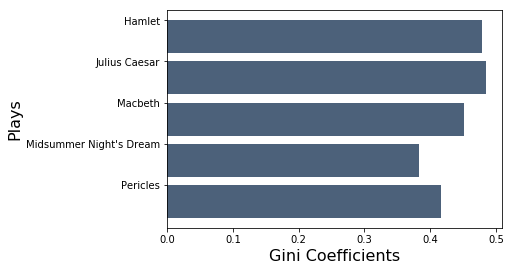

In [116]:
# use the gini function to calculate the gini coefficient of the eigenvector centralities for each of the 5 plays and create a bar chart
gini_table = Table().with_columns('Plays', play_names,
                                  'Gini Coefficients', gini_coefficients)
gini_table.barh('Plays', 'Gini Coefficients')

In [124]:
# Do the same for the percentage in the top quartile.
top_quartile_list = []
for play in play_tables:
    eigenvector_values = play.column('Eigenvector Centrality')
    top_quartile = np.percentile(eigenvector_values, 25)
    top_eigenvector_values = play.where('Eigenvector Centrality', are.above(top_quartile)).column('Eigenvector Centrality')
    top_quartile_list.append(gini(top_eigenvector_values))
    

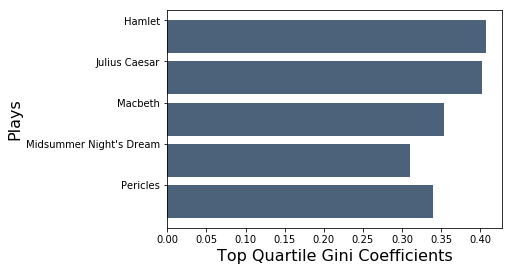

In [128]:
top_quartile_table = Table().with_columns('Plays', play_names,
                                          'Top Quartile Gini Coefficients', top_quartile_list)
top_quartile_table.barh('Plays', 'Top Quartile Gini Coefficients')

Much of this code is adapted from http://www.adampalay.com/blog/2015/04/17/shakespeare-social-networks/ .